In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

# Module 11 Lab - Model Evaluation

## Directions


The due dates for each are indicated in the Syllabus and the course calendar. If anything is unclear, please email EN685.648@gmail.com the official email for the course or ask questions in the Lab discussion area on Blackboard.

The Labs also present technical material that augments the lectures and "book".  You should read through the entire lab at the start of each module.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
Please follow the directions and make sure you provide the requested output. Failure to do so may result in a lower grade even if the code is correct or even 0 points.
</div>

1. Show all work/steps/calculations using Code and Markdown cells.
2. Submit your notebook (.ipynb).
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear
import models

sns.set(style="whitegrid")
# load whatever other libraries you need including models.py

## Model Evaluation and Improvement

As we saw in both the Linear Regression and Logistic Regression modules, there is a Statistician's view of Model Evaluation (and perhaps, Improvement) and a Machine Learning view of Model Evaluation and Improvement.

We'll be working with the **insurance data**.

**1. Load the data, perform your transformations, and using the Bootstrap version of the Linear Regression function, estimate your final model from Lab 10 and show the Bootstrap results** (You can also use the final model from the Solution if you like).

Here we load in the data and make sure it loads in correctly.

In [4]:
insurance = pd.read_csv("https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/insurance.csv", header=0)

In [5]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


It looks good to me. I'll be using the final model from the Lab 10 Solution. We had a model where `charges` was the target variable and our features included `age_sq`, `male`, `bmi`, `smoke_yes`, `smoke_yes:bmi`, `smoke_yes:bmi_above_30`, and `children`.

Let's make sure we properly transform our variables correctly so we can use them in our model. Age is easy to square so we do that first, and can create the one hot encodings for our categorical variables sex -> male and smoker -> smokes_yes. Then we just apply a lambda function to get an encoding for bmi over 30 and we should be set.

In [7]:
insurance['age_sq'] = insurance['age'] ** 2

insurance = pd.concat([insurance, pd.get_dummies(insurance["sex"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["smoker"], prefix="smoke")], axis=1)

insurance["bmi_above_30"] = insurance.bmi.apply(lambda bmi: 1 if bmi > 30.0 else 0)

Let's check our variables are in the dataframe

In [8]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges,age_sq,female,male,smoke_no,smoke_yes,bmi_above_30
0,19,female,27.900,0,yes,southwest,16884.92400,361,True,False,False,True,0
1,18,male,33.770,1,no,southeast,1725.55230,324,False,True,True,False,1
2,28,male,33.000,3,no,southeast,4449.46200,784,False,True,True,False,1
3,33,male,22.705,0,no,northwest,21984.47061,1089,False,True,True,False,0
4,32,male,28.880,0,no,northwest,3866.85520,1024,False,True,True,False,0


Looks good to me. Now we can recreate this model and use bootstrap for linear regression from our models.py file.

In [9]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + bmi_above_30 + smoke_yes:bmi_above_30 + children"
final = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(final)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,2169.21,319.43,3982.24
age_sq,$\beta_{1}$,-517.49,-1008.83,-40.46
male,$\beta_{2}$,1479.18,-3111.80,4731.14
bmi,$\beta_{3}$,3.34,3.17,3.57
smoke_yes,$\beta_{4}$,-3.22,-64.55,57.69
smoke_yes:bmi,$\beta_{5}$,471.11,334.76,646.93
bmi_above_30,$\beta_{6}$,102.95,-826.08,883.89
smoke_yes:bmi_above_30,$\beta_{7}$,15122.63,13304.62,16825.96
children,$\beta_{8}$,651.45,525.86,828.97


Note I include bmi_above_30 as a separate variable here because the `bootstrap_linear_regression` function was not working without including it in the model before the interaction term, though it's not necessary as we see the 95% BCI contains 0 and it may have an unexpected sign.

Here we have the estimates of the coefficients in the model for the bootstrap. We see an $R^2$ of 87% and a $\sigma$ of 4380.25. Which is about a third of the original as we can see below

In [10]:
print('Original Std: ', '%.2f' % np.std(insurance['charges']))
print('Model Sigma: ', '%.2f' % final['sigma'])

Original Std:  12105.48
Model Sigma:  4380.25


**2. Perform three rounds of 10-fold cross validation, estimating $R^2$ and $\sigma$ each round. Using the results for the test data, calculate 95% Bootstrap estimates of the credible intervals for each.** Comment on these intervals and the intervals from above. Are the average values different? Are the intervals different?

I'll be using the `sklearn` functions here to perform the cross validation, but note we could also make our own if we are inclined to do so. We need to first prepare our x's and y's in order to use the library properly.

In [11]:
from sklearn import datasets

In [12]:
X, y = datasets.load_iris(return_X_y=True)

Adding the interaction terms to the dataframe so we can select it easily in the next step.

In [13]:
insurance['interaction1'] = insurance['smoke_yes']*insurance['bmi']
insurance['interaction2'] = insurance['smoke_yes']*insurance['bmi_above_30']

Here is our 'x' data, we select all the observations with the features we want.

In [14]:
x = insurance.loc[:, ['age_sq', 'male', 'bmi', 'smoke_yes', 
                    'interaction1',
                    'bmi_above_30', 'interaction2',
                    'children']].values
type(x)

numpy.ndarray

And here we simply select the target variable

In [15]:
y = insurance['charges'].values


Now we can create our cross validation using `sklearn`

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score

We want to use a linear regression model

In [17]:
model = linear.LinearRegression()

Note we use negative mean squared error as our estimator, since this function uses a unified scoring API that maximizes the score, and we want to minimize our loss. This scoring simply returns the mse values multiplied by -1, and we can use the absolute value for our bootstrapping.

We can look at the $R^2$ and $\sigma$ values as well here

In [18]:
scores1_mse = abs(cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=10))
scores1_r2 = abs(cross_val_score(model, x, y, scoring='r2', cv=10))

print(f'R2 = {round(np.mean(scores1_r2),2)}')
print(f'Sigma = {round(np.mean(np.sqrt(scores1_mse)),2)}')

R2 = 0.87
Sigma = 4344.29


An $R^2$ of about 86% and $\sigma$ of 4355 for this model, pretty similar to what we found in question 1 (values of 87% and 4380, respectively).

We will perform the cross validation again for 2 more rounds, making sure we shuffle the data each time so we get different values for the MSE.

In [19]:
# this shuffles the observations in the dataframe
insurance = insurance.sample(frac=1).reset_index(drop=True)

We grab the features and target variables again and apply a 10 fold cross validation again and find the $R^2$ and $\sigma$ each time. We will compare each round at the end.

In [20]:
x = insurance.loc[:, ['age_sq', 'male', 'bmi', 'smoke_yes', 
                    'interaction1',
                    'bmi_above_30', 'interaction2',
                    'children']].values
y = insurance['charges'].values

In [21]:
scores2_mse = abs(cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=10))
scores2_r2 = abs(cross_val_score(model, x, y, scoring='r2', cv=10))

print(f'R2 = {round(np.mean(scores2_r2),2)}')
print(f'Sigma = {round(np.mean(np.sqrt(scores2_mse)),2)}')

R2 = 0.87
Sigma = 4327.57


And one more time for round 3. Putting it all together

In [22]:
# this shuffles the observations in the dataframe
insurance = insurance.sample(frac=1).reset_index(drop=True)

x = insurance.loc[:, ['age_sq', 'male', 'bmi', 'smoke_yes', 
                    'interaction1',
                    'bmi_above_30', 'interaction2',
                    'children']].values
y = insurance['charges'].values

scores3_mse = abs(cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=10))
scores3_r2 = abs(cross_val_score(model, x, y, scoring='r2', cv=10))

print(f'R2 = {round(np.mean(scores3_r2),2)}')
print(f'Sigma = {round(np.mean(np.sqrt(scores3_mse)),2)}')

R2 = 0.87
Sigma = 4352.69


Pretty similar values for each round of cross validation. Now we have 30 values of the mean squared error and can perform bootstrapping with our usual `bootstrap_sample` function from Lab 7.

In [23]:
mse_all = np.concatenate([scores1_mse, scores2_mse, scores3_mse])
r2_all = np.concatenate([scores1_r2, scores2_r2, scores3_r2])
sigma_all = np.concatenate([np.sqrt(scores1_mse), np.sqrt(scores2_mse),np.sqrt(scores3_mse)])

In [24]:
def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

In [25]:
posterior_mse = bootstrap_sample(mse_all, np.mean, 1000)
posterior_r2 = bootstrap_sample(r2_all, np.mean, 1000)
posterior_sigma = bootstrap_sample(sigma_all, np.mean, 1000)

We can look at a histogram of the posterior as well but I don't think it's necessary or interesting here. We can move on to looking at the 95% BCI

In [26]:
print( "95% BCI for mse theta:", stats.mstats.mquantiles(posterior_mse, [0.025, 0.975]))
print( "95% BCI for r2 theta:",stats.mstats.mquantiles(posterior_r2, [0.025, 0.975]))
print( "95% BCI for sigma:", stats.mstats.mquantiles(posterior_sigma, [0.025, 0.975]))

95% BCI for mse theta: [17151068.01786755 21521592.90543891]
95% BCI for r2 theta: [0.84902179 0.88178042]
95% BCI for sigma: [4101.44617692 4579.77853027]


We see for our $R^2$ we have a range of 0.847 to 0.878, compared to part 1 where the range was 0.84 to 0.90. We have a tighter range from the cross validation and bootstrapping. Our $\sigma$ range here is 4141 to 4575, compared to part 1 of 3909 to 4885, roughly. Again we see a bit of a tighter range with the cross validation process.

In [27]:
from tabulate import tabulate

In [28]:
data = [
    ['Part 1', final['r_squared'], final['sigma']],
    ['CV1', np.mean(scores1_r2), np.mean(np.sqrt(scores1_mse))],
    ['CV2', np.mean(scores2_r2), np.mean(np.sqrt(scores2_mse))],
    ['CV3', np.mean(scores3_r2), np.mean(np.sqrt(scores3_mse))],
]

tabulate(data, headers=['$R^2$', '$\sigma$'], tablefmt='html')

,$R^2$,$\sigma$
Part 1,0.869953,4380.25
CV1,0.866359,4344.29
CV2,0.865652,4327.57
CV3,0.865006,4352.69


As we already saw, the average values for these statistics are pretty much the same between part 1 and the cross validation techniques, with the $\sigma$ for part 1 being slightly higher. Overall however we get very similar results.

**3. Using Learning Curves and $\sigma$ as your evaluation metric determine if more data will improve the estimation of the model.**

For this part I'll be using the code from *Fundamentals, page 878* in order to calculate our learning curves and standard error.

In [32]:
import collections
from patsy.highlevel import dmatrices

In [33]:
def sse(results):
    errors = results['residuals']
    n = len(errors)
    squared_error = np.sum([e**2 for e in errors])
    return np.sqrt((1.0/n)*squared_error)

In [31]:
def chunk(xs, n):
    k,m = divmod(len(xs), n)
    return [xs[i*k + min(i,m):(i+1)*k + min(i+1, m)] for i in range(n)]

In [30]:
def data_collection():
    result = dict()
    result['train'] = collections.defaultdict(list)
    result['test'] = collections.defaultdict(list)
    return result


In [40]:
def learning_curves(algorithm, formula, data, evaluate, fold_count=10,
                    repetitions=3, increment=1):
    indices = list(range(len(data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]:
                train_chunk_size = int(np.ceil((i/100)*len(train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                result = algorithm(formula, data=train_data_chunk)
                model = result['model']
                y, X = dmatrices(formula, train_data_chunk, return_type='matrix')
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results['train'][i].append(metric)

                y, X = dmatrices(formula, test_data, return_type='matrix')
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results['test'][i].append(metric)

    statistics = {}
    for k, v in results['train'].items():
        statistics[k] = (np.mean(v), np.std(v))
    results['train'] = statistics

    statistics = {}
    for k, v in results['test'].items():
        statistics[k] = (np.mean(v), np.std(v))
    results['test'] = statistics
    return results


Now we can get results for our learning curves using standard error (sse) and a linear regression model for our data.

In [37]:
data = {}
data['charges'] = insurance['charges']
data['age_sq'] = insurance['age_sq']
data['male'] = insurance['male']
data['bmi'] = insurance['bmi']
data['smoke_yes'] = insurance['smoke_yes']
data['bmi_above_30'] = insurance['bmi_above_30']
data['children'] = insurance['children']

In [41]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + bmi_above_30 + smoke_yes:bmi_above_30 + children"
results = learning_curves(models.linear_regression, model, insurance, sse)


Using the functions from *Fundamentals, page 880* and on, we can plot our results for the training data and test data to compare.

In [43]:
def results_to_curves(curve, results):
    all_statistics = results[curve]
    keys = list(all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m,s = all_statistics[k]
        mean.append(m)
        upper.append(m + 2 * s)
        lower.append(m - 2 * s)
    return keys, lower, mean, upper

In [44]:
def plot_learning_curves(results, metric, desired=None, zoom=False, credible=True):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1,1,1)

    xs, train_lower, train_mean, train_upper = results_to_curves('train', results)
    _, test_lower, test_mean, test_upper = results_to_curves('test', results)

    axes.plot(xs, train_mean, color='steelblue', label='train')
    axes.plot(xs, test_mean, color='firebrick', label='test')

    if credible:
        axes.fill_between(xs, train_upper, train_lower, color='steelblue', alpha=0.25)
        axes.fill_between(xs, test_upper, test_lower, color='firebrick', alpha=0.25)

    if desired:
        if type(desired) is tuple:
            axes.axhline((desired[0] + desired[1]) / 2.0, color='gold', label='desired')

            axes.fill_between(xs, desired[1], desired[0], color='gold', alpha=0.25)
        else:
            axes.axhline(desired, color='gold', label='desired')
    
    axes.legend()
    axes.set_xlabel('training set (%)')
    axes.set_ylabel(metric)
    axes.set_title('Learning Curves')

    if zoom:
        y_lower = int(0.9*np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int(1.1*np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()


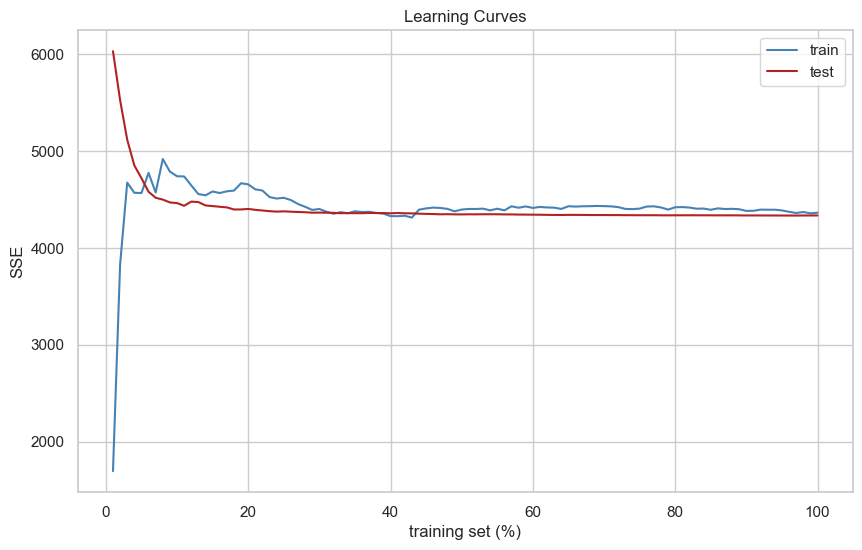

In [48]:
plot_learning_curves(results, r'SSE', credible=False)

We see here that the training and test curves start to converge around 30% of the training set, and the SSE is around 4400-4500. Let's zoom in for a closer look.

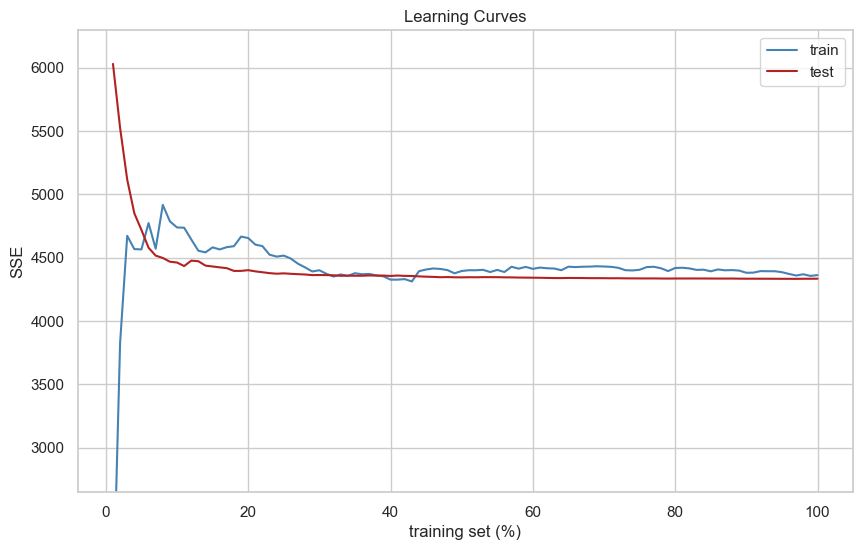

In [49]:
plot_learning_curves(results, r'SSE', credible=False, zoom=True)

We can see the SSE around the 30% and higher of the training data is definitely around the 4400 mark. This is slightly higher but still consistent with the SSE results we found for parts 1 and 2. I don't believe getting more data will help, as we do have a pretty good convergence by the time we evaluate 100% of the data in training and test sets.

**4. It was shown that `age_sq` improved the performance of the model. Perhaps a different polynomial would have been better. Generate Validation Curves for $age_n$ where `n` = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5] and select the best transformation.**

In order to get our validation curves, I will use the functions from *Fundamentals, page 887* and pretend I know what's going on.

In [54]:
def validation_curves(algorithm, formulas, data, values, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len(data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i, p in enumerate(zip(formulas, values)):
                f, v = p
                result = algorithm(f, train_data, v)
                model = result['model']
                y, X = dmatrices(f, train_data, return_type='matrix')
                result = models.summarize(f, X, y, model)
                metric = evaluate(result)
                results['train'][i].append(metric)

                y, X = dmatrices(f, test_data, return_type='matrix')
                result = models.summarize(f, X, y, model)
                metric = evaluate(result)
                results['test'][i].append(metric)

    statistics = {}
    for k, v in results['train'].items():
        statistics[k] = (np.mean(v), np.std(v))
    results['train'] = statistics

    statistics = {}
    for k, v in results['test'].items():
        statistics[k] = (np.mean(v), np.std(v))
    results['test'] = statistics
    return results


In [ ]:
charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + bmi_above_30 + smoke_yes:bmi_above_30 + children"

Let's try the difference values for age_sq

In [67]:
values = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]

formulas = []
formula = 'charges ~ male + bmi + smoke_yes + smoke_yes:bmi + bmi_above_30 + smoke_yes:bmi_above_30 + children '

for v in values:
    a = f'age_{v}'
    a = a.replace('.', '_')
    insurance[f'{a}'] = insurance['age']**v
    
    f = f'charges ~ male + bmi + smoke_yes + smoke_yes:bmi + bmi_above_30 + smoke_yes:bmi_above_30 + children + {a}'
    formulas.append(f)

def f(formula, data, v):
    return models.linear_regression(formula, data, style='linear')

result = validation_curves(f, formulas, insurance, values, lambda r: r['sigma'])

Now we can look at some plots

In [68]:
def plot_validation_curves(results, metric, parameter, values, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1,1,1)

    xs, train_lower, train_mean, train_upper = results_to_curves('train', results)
    _, test_lower, test_mean, test_upper = results_to_curves('test', results)

    axes.plot(values, train_mean, color='steelblue')
    axes.fill_between(values, train_upper, train_lower, color='steelblue', alpha=0.25, label='train')

    axes.plot(values, test_mean, color='firebrick')
    axes.fill_between(values, test_upper, test_lower, color='firebrick', alpha=0.25, label='test')

    axes.legend()
    axes.set_xlabel(parameter)
    axes.set_ylabel(metric)
    axes.set_title('Validation Curves')

    if zoom:
        y_lower = int(0.9*np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int(1.1*np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()

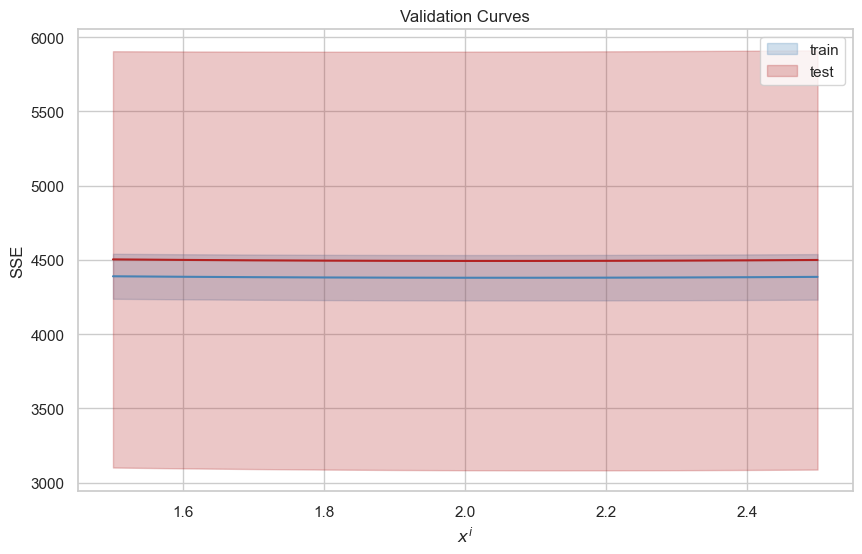

In [69]:
plot_validation_curves(result, 'SSE', r'$age^i$', values)

Hmm we don't see much of a difference here. Of course our values for the age parameter are not too different from each other, but we might still expect a notable difference between say 1.5 and 2.5. Let's try zooming to see if that makes a difference.

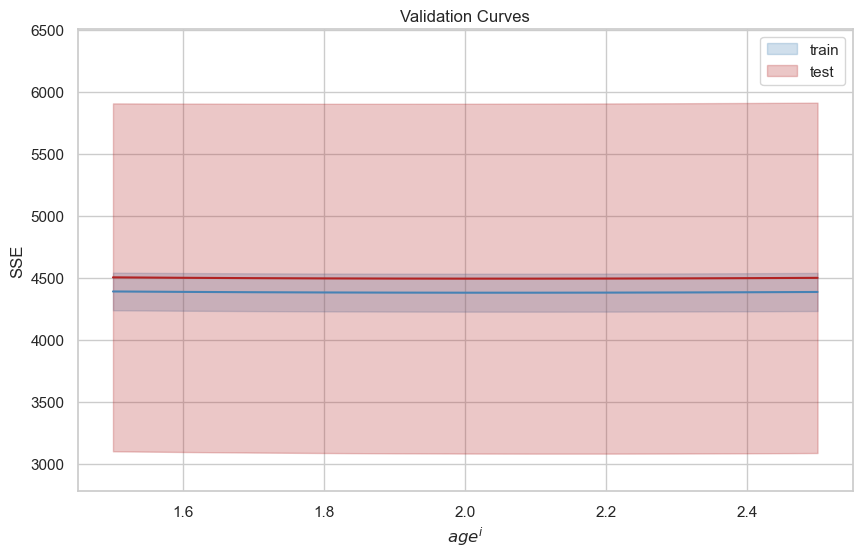

In [70]:
plot_validation_curves(result, 'SSE', r'$age^i$', values, zoom=True)

Pretty much the same. It doesn't seem like changing these values for the age variable makes much of a difference, but maybe they are just too close together. We might also try values of 0.5 and 4 to see how they look, but for brevity I will not include it here. There may just be too many other variables in the model so that slightly changing age here does not make as much of a difference as we would like to see.

**5. Using Ridge Regression to estimate a model for the insurance data. Compare it with your final Linear Regression model.** (If you get far ahead, you may need to write your own function. Here are the sklearn docs: http://scikit-learn.org/stable/modules/linear_model.html)